In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel(open('Online Retail2.xlsx', 'rb'))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
# check for missing values
df.isnull().sum()

# remove missing values
df.dropna(inplace=True)

In [ ]:
df['StockCode']= df['StockCode'].astype(str)

In [ ]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [ ]:
df['CustomerID']

0         17850.0
1         17850.0
2         17850.0
3         17850.0
4         17850.0
           ...   
541904    12680.0
541905    12680.0
541906    12680.0
541907    12680.0
541908    12680.0
Name: CustomerID, Length: 406829, dtype: float64

In [ ]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [ ]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:04<00:00, 787.28it/s]


In [ ]:
purchases_train[0]

['21485',
 '22114',
 '21484',
 '84029E',
 '23355',
 '21484',
 '21485',
 '22114',
 '22114',
 '23355',
 '84029E',
 '22111',
 '21485',
 '23355',
 '22114',
 '21484',
 '22111',
 '22111',
 '21484',
 '84029E',
 '23355']

In [ ]:
i = customers_train[0]
train_df[train_df["CustomerID"] == i]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
257649,559539,21770,OPEN CLOSED METAL SIGN,1,2011-07-10 12:28:00,4.95,18024.0,United Kingdom
257650,559539,82582,AREA PATROLLED METAL SIGN,1,2011-07-10 12:28:00,2.10,18024.0,United Kingdom
257651,559539,21165,BEWARE OF THE CAT METAL SIGN,8,2011-07-10 12:28:00,1.69,18024.0,United Kingdom
257652,559539,21164,HOME SWEET HOME METAL SIGN,1,2011-07-10 12:28:00,2.95,18024.0,United Kingdom
257653,559539,21455,PAINTED YELLOW WOODEN DAISY,3,2011-07-10 12:28:00,0.85,18024.0,United Kingdom
257654,559539,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,72,2011-07-10 12:28:00,1.25,18024.0,United Kingdom
257655,559539,22228,BUNNY WOODEN PAINTED WITH BIRD,1,2011-07-10 12:28:00,0.39,18024.0,United Kingdom
257656,559539,22232,JIGSAW TOADSTOOLS 3 PIECE,1,2011-07-10 12:28:00,0.59,18024.0,United Kingdom
257657,559539,22231,JIGSAW TREE WITH BIRDHOUSE,1,2011-07-10 12:28:00,0.59,18024.0,United Kingdom
257658,559539,22233,JIGSAW RABBIT AND BIRDHOUSE,1,2011-07-10 12:28:00,0.59,18024.0,United Kingdom


In [ ]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1147.70it/s]


In [ ]:
# train word2vec model
model = Word2Vec(window = 6, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3614955, 3652160)

In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

Word2Vec(vocab=3180, size=100, alpha=0.03)


In [ ]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3180, 100)

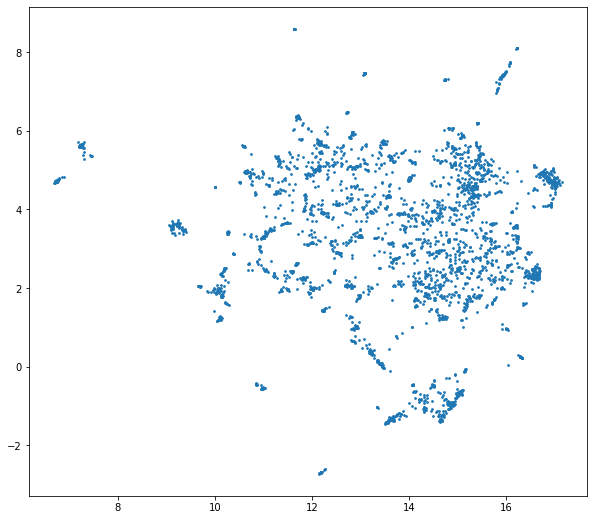

In [ ]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [ ]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [ ]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [ ]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms      

In [ ]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.7838361859321594),
 ('5 STRAND GLASS NECKLACE CRYSTAL', 0.7748433947563171),
 ('GREEN HEART OF GLASS BRACELET', 0.7432068586349487),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.743035614490509),
 ('PINK BOUDICCA LARGE BRACELET', 0.7418177127838135),
 ('BLUE MURANO TWIST BRACELET', 0.7389339208602905)]

In [ ]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [ ]:
len(purchases_val[0])

312

In [ ]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [ ]:
similar_products(aggregate_vectors(purchases_val[0]))

[('WOODEN PICTURE FRAME WHITE FINISH', 0.7241352796554565),
 ('WOOD 2 DRAWER CABINET WHITE FINISH', 0.7051393985748291),
 ('WOODEN FRAME ANTIQUE WHITE ', 0.692671537399292),
 ('3 DRAWER ANTIQUE WHITE WOOD CABINET', 0.68724524974823),
 ('CHALKBOARD KITCHEN ORGANISER', 0.6436696648597717),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.6364970207214355)]

In [ ]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('3 DRAWER ANTIQUE WHITE WOOD CABINET', 0.7346889972686768),
 ('WOODEN FRAME ANTIQUE WHITE ', 0.7297999858856201),
 ('WHITE HANGING HEART T-LIGHT HOLDER', 0.7056260704994202),
 ('WOODEN PICTURE FRAME WHITE FINISH', 0.6896355152130127),
 ('WOOD BLACK BOARD ANT WHITE FINISH', 0.6390194892883301),
 ('HANGING MEDINA LANTERN SMALL', 0.6095050573348999)]